In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


**FUNCIONS DE L'APP**

In [2]:
def carregar_dades(ciutat):
    # Població
    df_poblacio = pd.read_csv(f'dat/{ciutat}/poblacio.csv', skiprows=10, sep=";", decimal=",")
    df_poblacio.rename(columns={"Unnamed: 0":"Any", "Total":"Població"}, inplace=True)
    df_poblacio = df_poblacio.set_index("Any")
    df_poblacio = df_poblacio[['Població']]
    
    # Densitat
    df_densitat = pd.read_csv(f'dat/{ciutat}/densitat.csv', skiprows=6, sep=";", decimal=',')
    df_densitat.rename(columns={"Unnamed: 0":"Any", "Superfície (km²)":"Superfície", "Densitat (hab./km²)":"Densitat"}, inplace=True)
    df_densitat.set_index("Any", inplace=True)
    df_densitat = df_densitat[['Superfície', 'Densitat']]
    
    # Naixements
    df_naixements = pd.read_csv(f'dat/{ciutat}/naixements.csv', skiprows=8, sep=";")
    df_naixements.rename(columns={"Unnamed: 0":"Any", "Total":"Naixements"}, inplace=True)
    df_naixements.set_index("Any", inplace=True)
    df_naixements = df_naixements[['Naixements']]
    
    # Defuncions
    df_defuncions = pd.read_csv(f'dat/{ciutat}/defuncions.csv', skiprows=7, sep=";")
    df_defuncions.rename(columns={"Unnamed: 0":"Any", "Total":"Defuncions"}, inplace=True)
    df_defuncions.set_index("Any", inplace=True)
    df_defuncions = df_defuncions[['Defuncions']]

    # Aturats
    df_atur = pd.read_csv(f'dat/{ciutat}/atur.csv', skiprows=6, sep=";", decimal=',')
    df_atur.rename(columns={"Unnamed: 0":"Any", "Sexe. Total":"Aturats"}, inplace=True)
    df_atur = df_atur.set_index("Any")
    df_atur = df_atur[['Aturats']]

    # Pensionistes
    df_pensionistes = pd.read_csv(f'dat/{ciutat}/pensionistes.csv', skiprows=7, sep=";")
    df_pensionistes.rename(columns={'Unnamed: 0':'Any', 'Total':'Pensionistes'}, inplace=True)
    df_pensionistes = df_pensionistes.set_index("Any")
    df_pensionistes = df_pensionistes[['Pensionistes']]

    # Habitatges acabats
    df_habit = pd.read_csv(f'dat/{ciutat}/habitatges_construits.csv', skiprows=10, sep=";")
    noves_col = {
        'Unnamed: 0':'Any',
        'Habitatges iniciats amb protecció oficial':'HPO iniciats',
        'Habitatges acabats amb protecció oficial':'HPO acabats'
    }
    df_habit.rename(columns=noves_col, inplace=True)
    df_habit.set_index('Any', inplace=True)
    df_habit = df_habit[['HPO acabats', 'Habitatges acabats']]

    # Vehicles
    df_vehicles = pd.read_csv(f'dat/{ciutat}/vehicles.csv', skiprows=6, sep=";")
    df_vehicles.rename(columns={'Unnamed: 0':'Any'}, inplace=True)
    df_vehicles.set_index('Any', inplace=True)
    df_vehicles = df_vehicles[['Turismes', 'Motocicletes']]

    # Renta Familiar Disponible per Habitant
    df_rdf = pd.read_csv(f'dat/{ciutat}/rfd.csv', skiprows=6, sep=";")
    df_rdf.rename(columns={"Unnamed: 0":"Any",'Per habitant (€)':'RFDH' }, inplace=True)
    df_rdf = df_rdf.set_index("Any")
    df_rdf = df_rdf[['RFDH']]

    # Saldo de migracions internes
    df_migracionsint = pd.read_csv(f'dat/{ciutat}/migracions_internes.csv', skiprows=7, sep=";", decimal=",")
    df_migracionsint.rename(columns={"Unnamed: 0":"Any", 'Total':'Migracions internes'}, inplace=True)
    df_migracionsint = df_migracionsint.set_index("Any")
    df_migracionsint = df_migracionsint[['Migracions internes']]

    # Saldo de migracions externes
    df_migracionsext = pd.read_csv(f'dat/{ciutat}/migracions_externes.csv', skiprows=8, sep=";", decimal=",")
    df_migracionsext.rename(columns={"Unnamed: 0":"Any", 'Total':'Migracions externes'}, inplace=True)
    df_migracionsext = df_migracionsext.set_index("Any")
    df_migracionsext = df_migracionsext[['Migracions externes']]
    
    df = pd.concat([df_poblacio, df_densitat, df_naixements, df_defuncions, df_migracionsint, df_migracionsext,
                    df_atur, df_pensionistes, df_habit, df_vehicles, df_rdf], axis=1).sort_index(ascending=True)
    
    return df

def neteja_dades (df):
    df = df.drop(range(1975,2010))
    df.drop(2025, inplace=True)
    df['Població'] = df['Població'].fillna(round(df['Densitat']* df['Superfície'], 0)) # Omplim els NAN amb Densitat * Superfície
    df.loc[2015, 'Pensionistes'] = round((df['Pensionistes'][2016]+df['Pensionistes'][2014])/2, 0) # Omplim els NAN amb una interpolació lineal
    df.loc[2010, 'Pensionistes'] = round(2 * df.loc[2011, 'Pensionistes'] - df.loc[2012, 'Pensionistes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2023, 'RFDH'] = round(2 * df.loc[2022, 'RFDH'] - df.loc[2021, 'RFDH'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'RFDH'] = round(2 * df.loc[2023, 'RFDH'] - df.loc[2022, 'RFDH'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'Migracions internes'] = round(2 * df.loc[2023, 'Migracions internes'] - df.loc[2022, 'Migracions internes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'Migracions externes'] = round(2 * df.loc[2023, 'Migracions externes'] - df.loc[2022, 'Migracions externes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.drop(columns='Superfície', inplace=True)
    return df

def afegir_taxes (df):
    df['Taxa natalitat'] = round(df.Naixements * 100 / df.Població, 2)
    df['Taxa mortalitat'] = round(df.Defuncions * 100 / df.Població, 2)
    df['Taxa atur'] = round(df.Aturats * 100 / df.Població, 2)
    df['Taxa dependència'] = round(df.Pensionistes * 100 / df.Població, 2)
    df['Taxa HPO'] = round(df['HPO acabats'] * 1000 / df.Població, 2)
    df['Taxa habitatges'] = round(df['Habitatges acabats'] * 1000 / df.Població, 2)
    df['Taxa turismes'] = round(df.Turismes * 100 / df.Població, 2)
    df['Taxa motocicletes'] = round(df.Motocicletes * 100 / df.Població, 2)
    return df


**CÀRREGA DE LES DADES I ANÀLISI EXPLORATORI**

In [3]:
ciutat = "Sabadell"
df = carregar_dades (ciutat)
df = neteja_dades (df)
df

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,Turismes,Motocicletes,RFDH
Any,,,,,,,,,,,,,
2010,207339.0,5486.6,2447.0,1650.0,-33.0,2086.0,18449.0,43260.0,384.0,922.0,92100.0,12285.0,16771.0
2011,206949.0,5496.7,2389.0,1644.0,449.0,2060.0,19225.4,43914.0,51.0,427.0,91228.0,12626.0,16878.0
2012,207939.0,5502.5,2301.0,1780.0,704.0,1602.0,20591.3,44568.0,618.0,667.0,90576.0,12859.0,16005.0
2013,207648.0,5494.8,2130.0,1685.0,740.0,1569.0,20689.1,44943.0,4.0,150.0,89695.0,13010.0,15854.0
2014,207444.0,5489.4,2099.0,1697.0,645.0,1734.0,18884.7,45282.0,0.0,226.0,89789.0,13285.0,16048.0
2015,207815.0,5499.2,2098.0,1757.0,271.0,2094.0,16947.1,45456.0,96.0,101.0,90905.0,13713.0,16651.0
2016,208246.0,5510.6,2154.0,1713.0,884.0,2476.0,14951.9,45629.0,7.0,81.0,93187.0,14282.0,17008.0
2017,209931.0,5555.2,2017.0,1771.0,815.0,3034.0,13440.8,45970.0,6.0,68.0,95808.0,14672.0,17215.0
2018,211734.0,5602.9,1875.0,1880.0,519.0,3638.0,12782.2,46314.0,0.0,209.0,97239.0,15330.0,17466.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 2010 to 2024
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Població             15 non-null     float64
 1   Densitat             15 non-null     float64
 2   Naixements           15 non-null     float64
 3   Defuncions           15 non-null     float64
 4   Migracions internes  15 non-null     float64
 5   Migracions externes  15 non-null     float64
 6   Aturats              15 non-null     float64
 7   Pensionistes         15 non-null     float64
 8   HPO acabats          15 non-null     float64
 9   Habitatges acabats   15 non-null     float64
 10  Turismes             15 non-null     float64
 11  Motocicletes         15 non-null     float64
 12  RFDH                 15 non-null     float64
dtypes: float64(13)
memory usage: 2.2 KB


In [5]:
df.describe()

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,Turismes,Motocicletes,RFDH
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,211769.733333,5605.506667,1987.333333,1825.933333,501.466667,3173.533333,15355.526667,45593.733333,94.466667,367.000000,94180.333333,14984.666667,17530.000000
std,4786.409070,125.284593,273.254112,159.261450,481.398983,1549.830307,3455.481828,1038.892093,174.544250,256.262421,3229.674965,2049.925179,1332.460077
min,206949.000000,5486.600000,1610.000000,1644.000000,-464.000000,1569.000000,11078.800000,43260.000000,0.000000,68.000000,89695.000000,12285.000000,15854.000000
25%,207731.500000,5497.950000,1745.000000,1705.000000,252.000000,2073.000000,12541.550000,45112.500000,5.000000,175.500000,91066.500000,13147.500000,16711.000000
50%,209931.000000,5555.200000,2017.000000,1780.000000,519.000000,2476.000000,14327.500000,45970.000000,22.000000,349.000000,95235.000000,14672.000000,17215.000000
75%,215782.000000,5715.350000,2142.000000,1885.000000,777.500000,3953.500000,18666.850000,46373.000000,90.000000,507.000000,96786.500000,16540.000000,18321.000000
max,221564.000000,5863.000000,2447.000000,2254.000000,1479.000000,6230.000000,20689.100000,46872.000000,618.000000,922.000000,98432.000000,18663.000000,20183.000000


In [6]:
df2 = afegir_taxes(df)
df2


,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,...,Motocicletes,RFDH,Taxa natalitat,Taxa mortalitat,Taxa atur,Taxa dependència,Taxa HPO,Taxa habitatges,Taxa turismes,Taxa motocicletes
Any,,,,,,,,,,,,,,,,,,,,,
2010,207339.0,5486.6,2447.0,1650.0,-33.0,2086.0,18449.0,43260.0,384.0,922.0,...,12285.0,16771.0,1.18,0.80,8.90,20.86,1.85,4.45,44.42,5.93
2011,206949.0,5496.7,2389.0,1644.0,449.0,2060.0,19225.4,43914.0,51.0,427.0,...,12626.0,16878.0,1.15,0.79,9.29,21.22,0.25,2.06,44.08,6.10
2012,207939.0,5502.5,2301.0,1780.0,704.0,1602.0,20591.3,44568.0,618.0,667.0,...,12859.0,16005.0,1.11,0.86,9.90,21.43,2.97,3.21,43.56,6.18
2013,207648.0,5494.8,2130.0,1685.0,740.0,1569.0,20689.1,44943.0,4.0,150.0,...,13010.0,15854.0,1.03,0.81,9.96,21.64,0.02,0.72,43.20,6.27
2014,207444.0,5489.4,2099.0,1697.0,645.0,1734.0,18884.7,45282.0,0.0,226.0,...,13285.0,16048.0,1.01,0.82,9.10,21.83,0.00,1.09,43.28,6.40
2015,207815.0,5499.2,2098.0,1757.0,271.0,2094.0,16947.1,45456.0,96.0,101.0,...,13713.0,16651.0,1.01,0.85,8.15,21.87,0.46,0.49,43.74,6.60
2016,208246.0,5510.6,2154.0,1713.0,884.0,2476.0,14951.9,45629.0,7.0,81.0,...,14282.0,17008.0,1.03,0.82,7.18,21.91,0.03,0.39,44.75,6.86
2017,209931.0,5555.2,2017.0,1771.0,815.0,3034.0,13440.8,45970.0,6.0,68.0,...,14672.0,17215.0,0.96,0.84,6.40,21.90,0.03,0.32,45.64,6.99
2018,211734.0,5602.9,1875.0,1880.0,519.0,3638.0,12782.2,46314.0,0.0,209.0,...,15330.0,17466.0,0.89,0.89,6.04,21.87,0.00,0.99,45.93,7.24


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 2010 to 2024
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Població             15 non-null     float64
 1   Densitat             15 non-null     float64
 2   Naixements           15 non-null     float64
 3   Defuncions           15 non-null     float64
 4   Migracions internes  15 non-null     float64
 5   Migracions externes  15 non-null     float64
 6   Aturats              15 non-null     float64
 7   Pensionistes         15 non-null     float64
 8   HPO acabats          15 non-null     float64
 9   Habitatges acabats   15 non-null     float64
 10  Turismes             15 non-null     float64
 11  Motocicletes         15 non-null     float64
 12  RFDH                 15 non-null     float64
 13  Taxa natalitat       15 non-null     float64
 14  Taxa mortalitat      15 non-null     float64
 15  Taxa atur            15 non-null     float

In [8]:
df2.describe()

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,...,Motocicletes,RFDH,Taxa natalitat,Taxa mortalitat,Taxa atur,Taxa dependència,Taxa HPO,Taxa habitatges,Taxa turismes,Taxa motocicletes
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,211769.733333,5605.506667,1987.333333,1825.933333,501.466667,3173.533333,15355.526667,45593.733333,94.466667,367.000000,...,14984.666667,17530.000000,0.942000,0.862000,7.282000,21.530667,0.451333,1.730000,44.470000,7.060000
std,4786.409070,125.284593,273.254112,159.261450,481.398983,1549.830307,3455.481828,1038.892093,174.544250,256.262421,...,2049.925179,1332.460077,0.147076,0.061899,1.768095,0.330075,0.839727,1.217673,1.006011,0.808234
min,206949.000000,5486.600000,1610.000000,1644.000000,-464.000000,1569.000000,11078.800000,43260.000000,0.000000,68.000000,...,12285.000000,15854.000000,0.730000,0.790000,5.000000,20.860000,0.000000,0.320000,42.980000,5.930000
25%,207731.500000,5497.950000,1745.000000,1705.000000,252.000000,2073.000000,12541.550000,45112.500000,5.000000,175.500000,...,13147.500000,16711.000000,0.810000,0.820000,5.900000,21.290000,0.025000,0.830000,43.650000,6.335000
50%,209931.000000,5555.200000,2017.000000,1780.000000,519.000000,2476.000000,14327.500000,45970.000000,22.000000,349.000000,...,14672.000000,17215.000000,0.960000,0.850000,6.620000,21.640000,0.100000,1.600000,44.420000,6.990000
75%,215782.000000,5715.350000,2142.000000,1885.000000,777.500000,3953.500000,18666.850000,46373.000000,90.000000,507.000000,...,16540.000000,18321.000000,1.030000,0.885000,9.000000,21.850000,0.425000,2.385000,45.265000,7.635000
max,221564.000000,5863.000000,2447.000000,2254.000000,1479.000000,6230.000000,20689.100000,46872.000000,618.000000,922.000000,...,18663.000000,20183.000000,1.180000,1.040000,9.960000,21.910000,2.970000,4.450000,45.980000,8.420000


**ANÀLISI DESCRIPTIU**

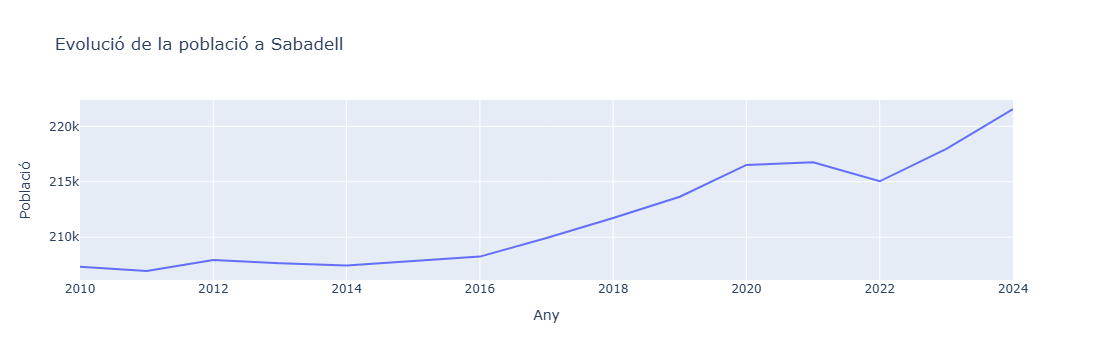

In [9]:
fig = px.line(df2, 
              y='Població',
              title=f'Evolució de la població a {ciutat}'
             )
fig.show()

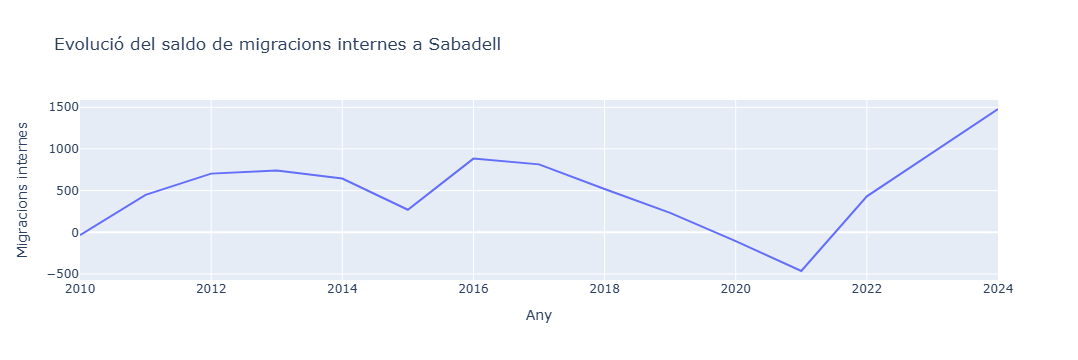

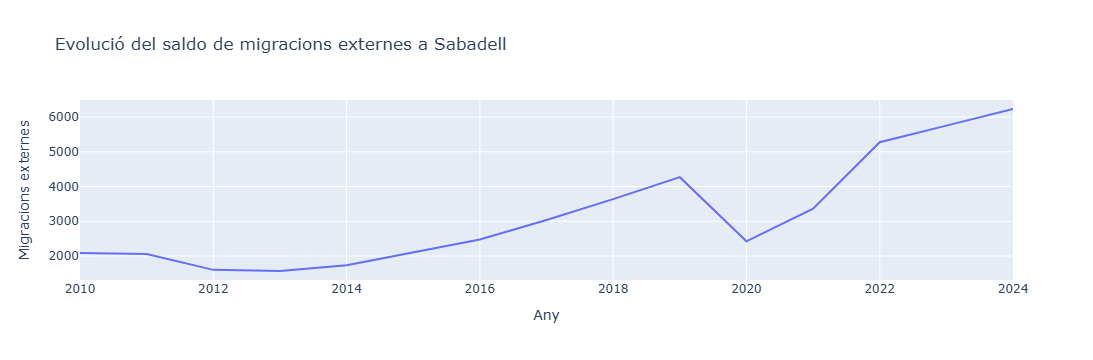

In [10]:
fig = px.line(df2, 
              y='Migracions internes',
              title=f'Evolució del saldo de migracions internes a {ciutat}'
             )
fig2 = px.line(df2,
               y='Migracions externes',
               title=f'Evolució del saldo de migracions externes a {ciutat}'
              )
fig.show()
fig2.show()

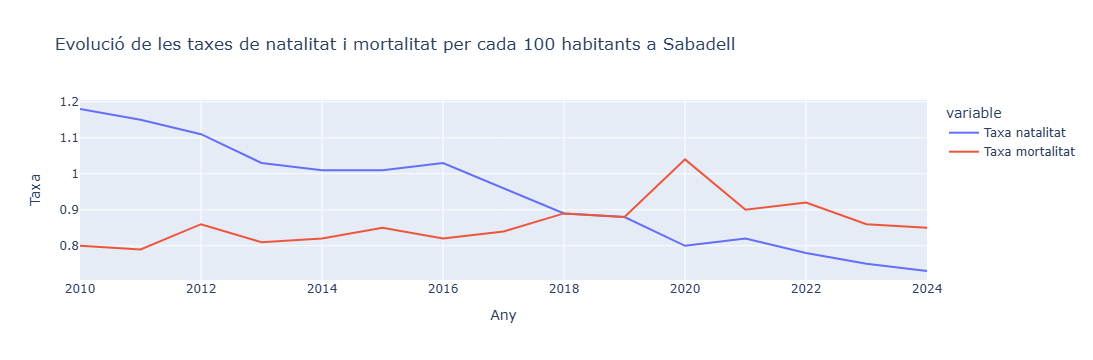

In [11]:
fig = px.line(df2, 
              y=['Taxa natalitat', 'Taxa mortalitat'],
              title=f'Evolució de les taxes de natalitat i mortalitat per cada 100 habitants a {ciutat}',
              labels={'value':'Taxa'}
             )
fig.show()

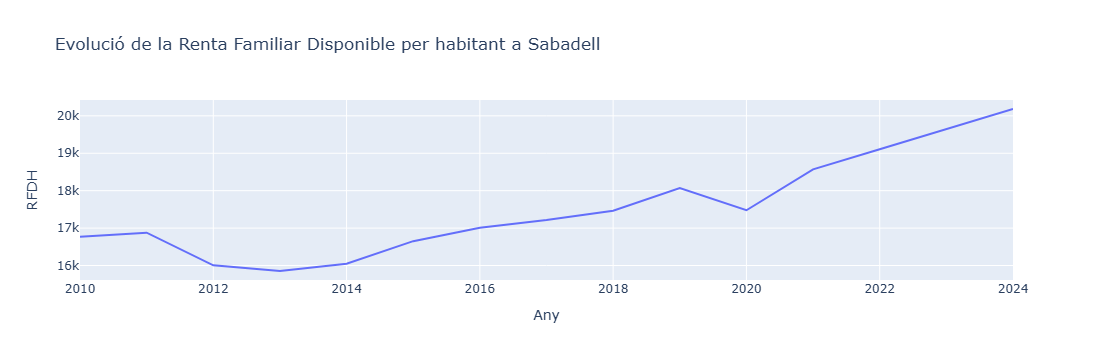

In [12]:
fig = px.line(df2, 
              y='RFDH',
              title=f'Evolució de la Renta Familiar Disponible per habitant a {ciutat}'
             )
fig.show()

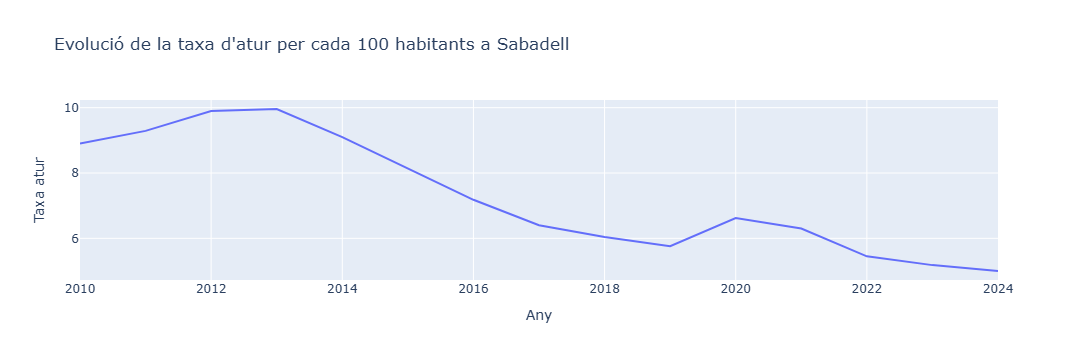

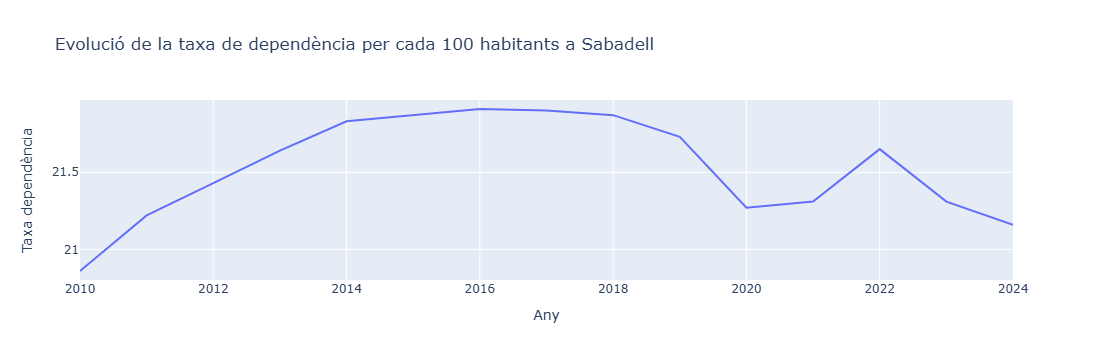

In [13]:
fig = px.line(df2, y='Taxa atur',
              title=f"Evolució de la taxa d'atur per cada 100 habitants a {ciutat}",
              labels={'value':"Taxa d'atur"}
             )
fig2 = px.line(df2, y='Taxa dependència',
               title=f"Evolució de la taxa de dependència per cada 100 habitants a {ciutat}",
               labels={'value':"Taxa de dependència"}
              )
fig.show()
fig2.show()

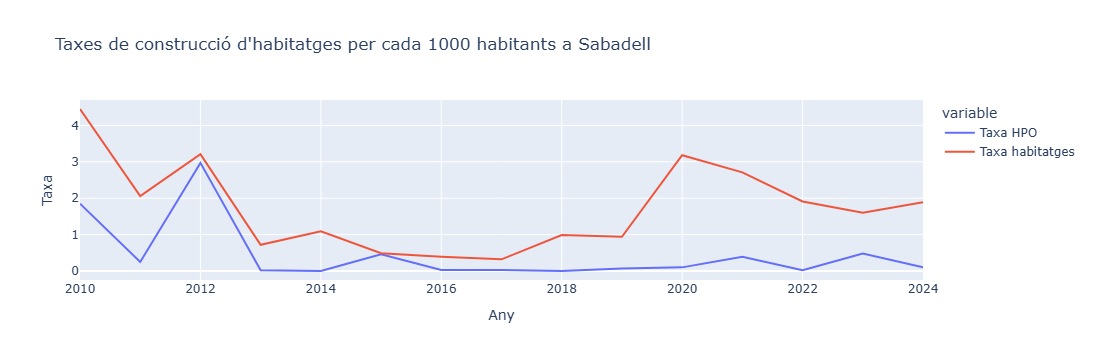

In [14]:
fig = px.line(df2,
              y=['Taxa HPO', 'Taxa habitatges'],
              title=f"Taxes de construcció d'habitatges per cada 1000 habitants a {ciutat}",
              labels={'value':'Taxa'}
             )
fig.show()

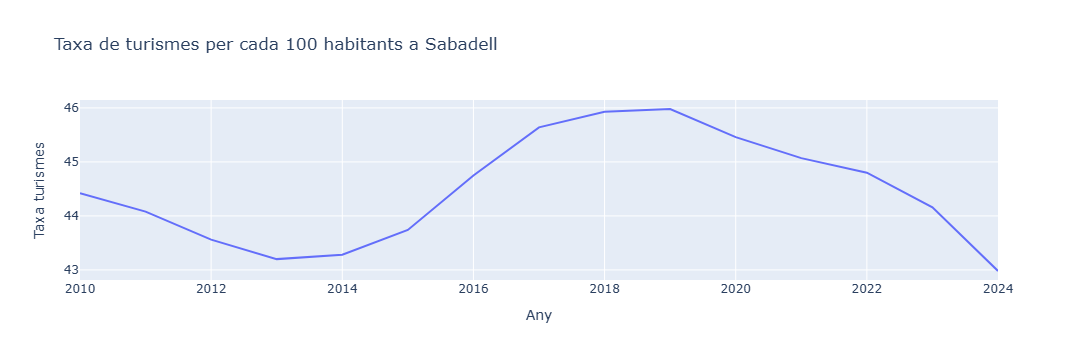

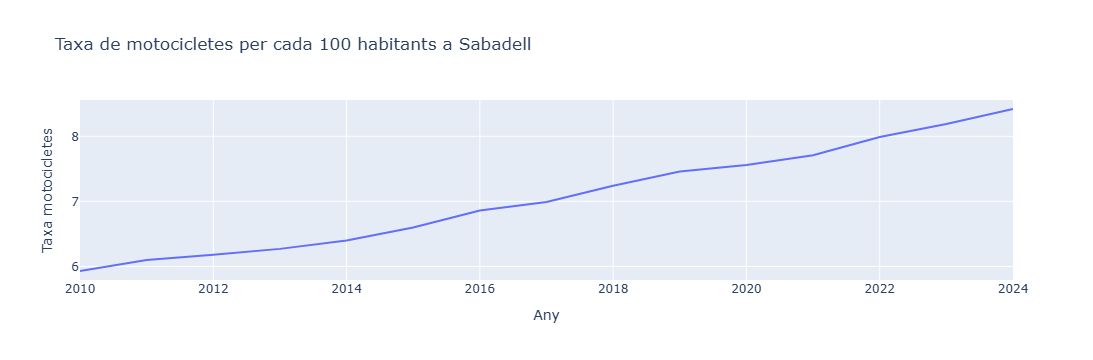

In [15]:
fig = px.line(df2, 
              y='Taxa turismes',
              title=f'Taxa de turismes per cada 100 habitants a {ciutat}'
             )
fig2 = px.line(df2, 
               y='Taxa motocicletes',
               title=f'Taxa de motocicletes per cada 100 habitants a {ciutat}'
              )
fig.show()
fig2.show()

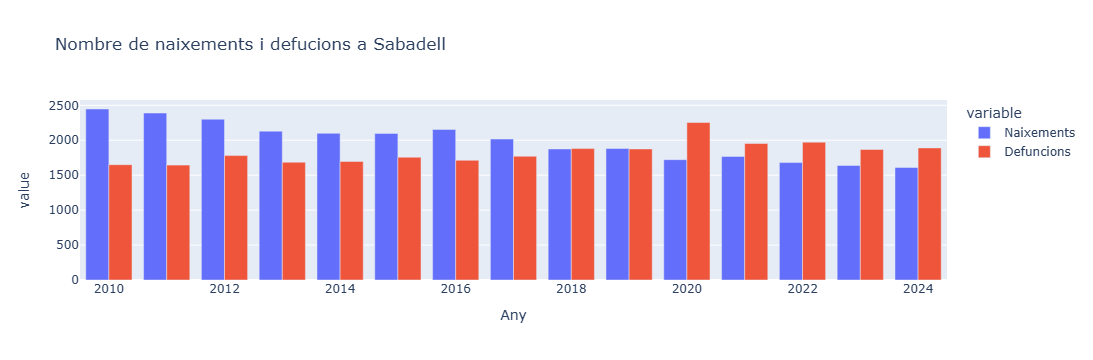

In [16]:
fig = px.bar(df2,
             y= ['Naixements', 'Defuncions'],
             barmode='group',
             title=f'Nombre de naixements i defucions a {ciutat}'
            )
fig.show()

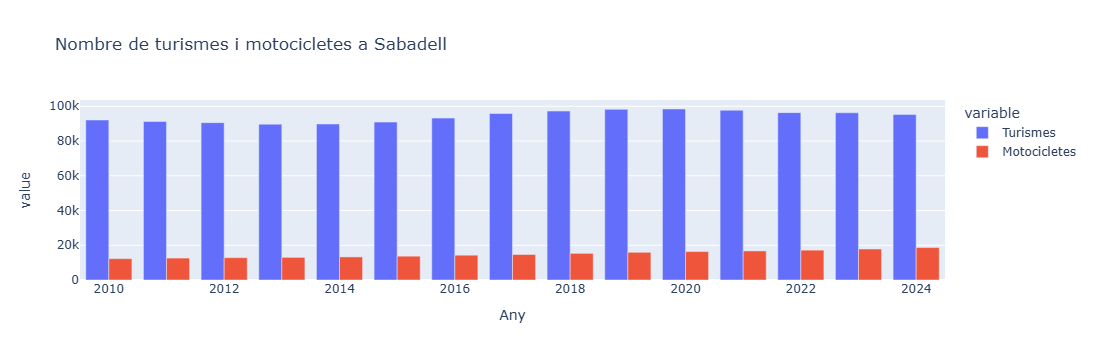

In [17]:
fig = px.bar(df2,
             y= ['Turismes', 'Motocicletes'],
             barmode='group',
             title=f'Nombre de turismes i motocicletes a {ciutat}'
            )
fig.show()

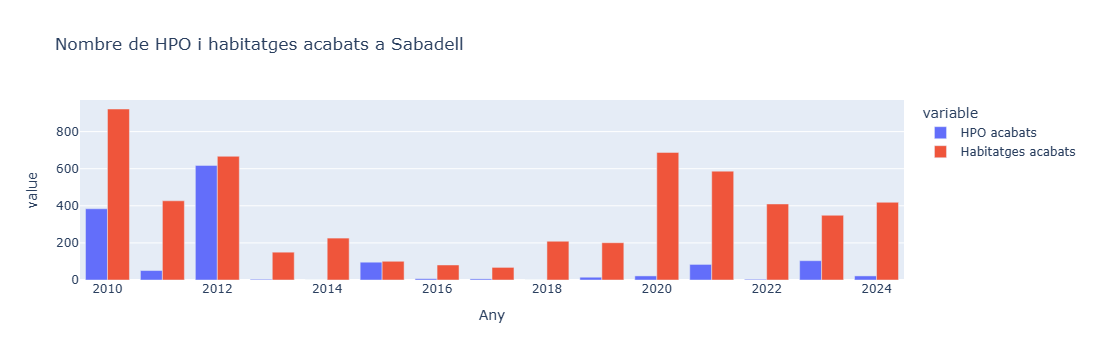

In [18]:
fig = px.bar(df2,
             y= ['HPO acabats', 'Habitatges acabats'],
             barmode='group',
             title=f"Nombre de HPO i habitatges acabats a {ciutat}"
            )
fig.show()

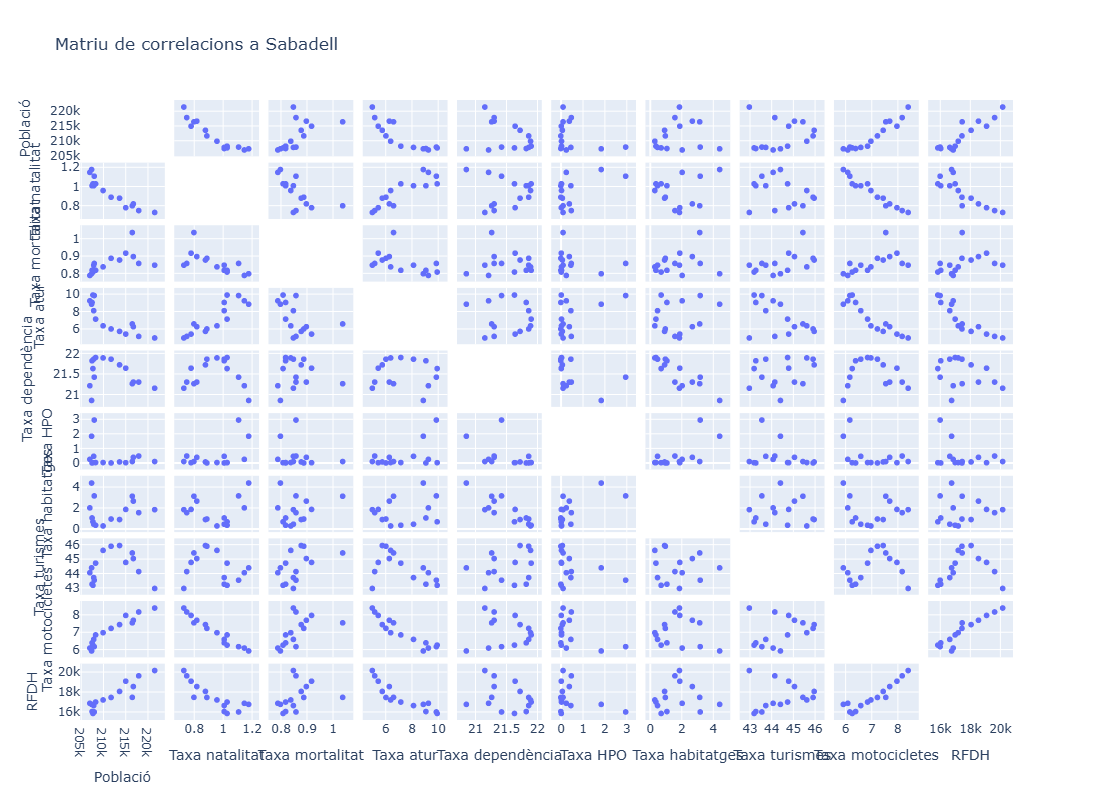

In [19]:
fig = px.scatter_matrix(
    df2,
    dimensions = ['Població', 'Taxa natalitat', 'Taxa mortalitat', 'Taxa atur', 'Taxa dependència',
                  'Taxa HPO', 'Taxa habitatges', 'Taxa turismes', 'Taxa motocicletes', 'RFDH'],
    height=800,
    width=800,
    title=f'Matriu de correlacions a {ciutat}'
)
fig.update_traces(diagonal_visible=False)  # Ocultar histogramas en la diagonal
fig.update_layout(
    dragmode='select',     # Permitir selección de puntos
    hovermode='closest',   # Mostrar datos al pasar el ratón
    font=dict(size=12)
)
fig.show()

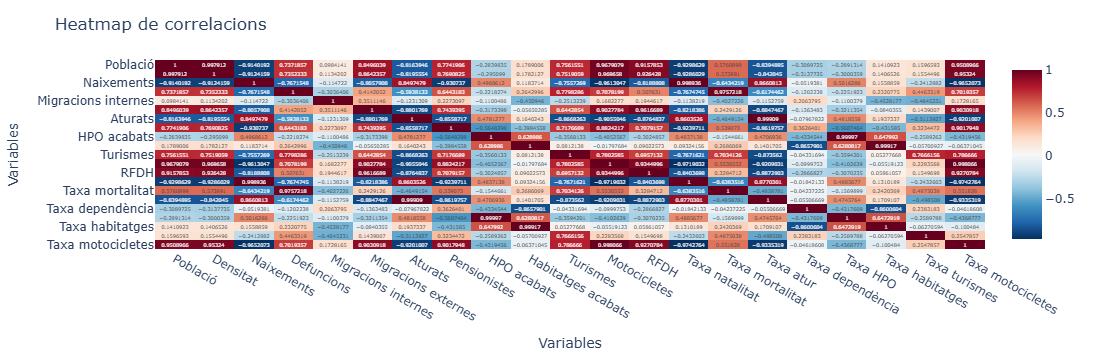

In [20]:
corr = df2.corr()
fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    aspect='auto'
)
fig.update_layout( title='Heatmap de correlacions', xaxis_title='Variables', yaxis_title='Variables' )
fig.show()

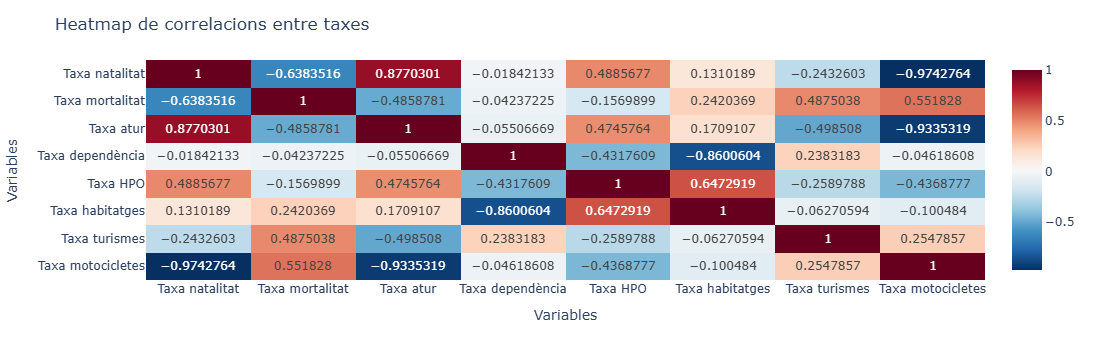

In [21]:
cols = [c for c in df.columns if 'Taxa' in c]
corr = df2[cols].corr()
fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    aspect='auto'
)
fig.update_layout( title='Heatmap de correlacions entre taxes', xaxis_title='Variables', yaxis_title='Variables' )
fig.show()

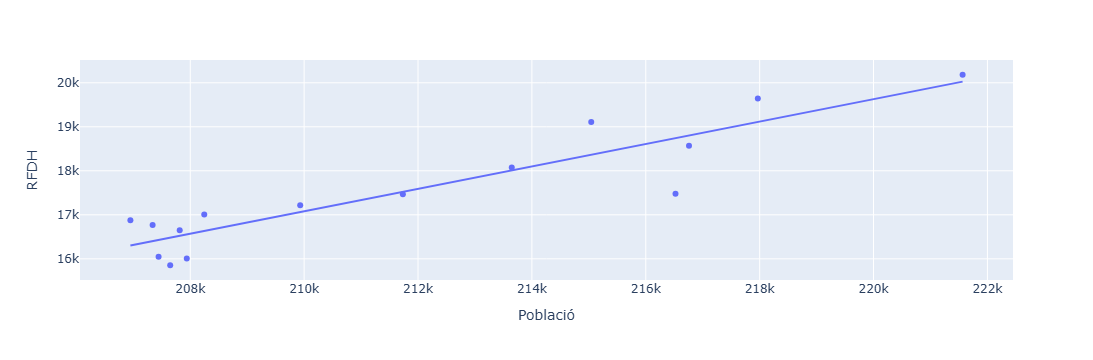

In [25]:
fig = px.scatter(df2, x='Població', y='RFDH', trendline='ols')
fig.show()

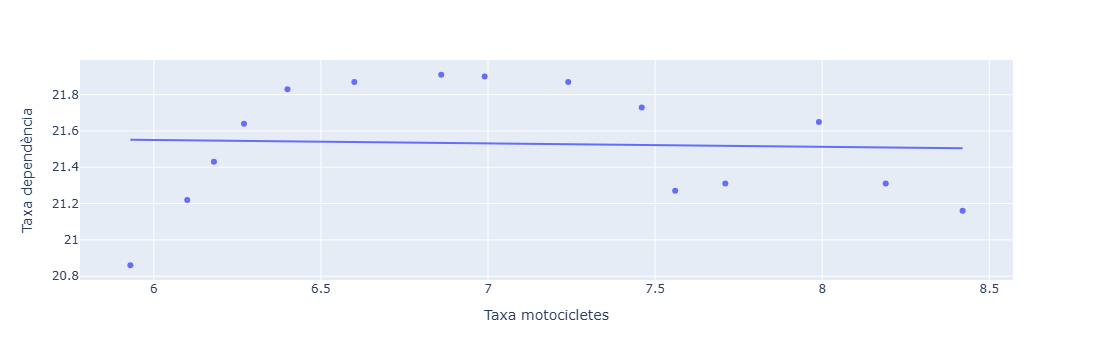

In [26]:
fig = px.scatter(df2, x='Taxa motocicletes', y='Taxa dependència', trendline='ols')
fig.show()

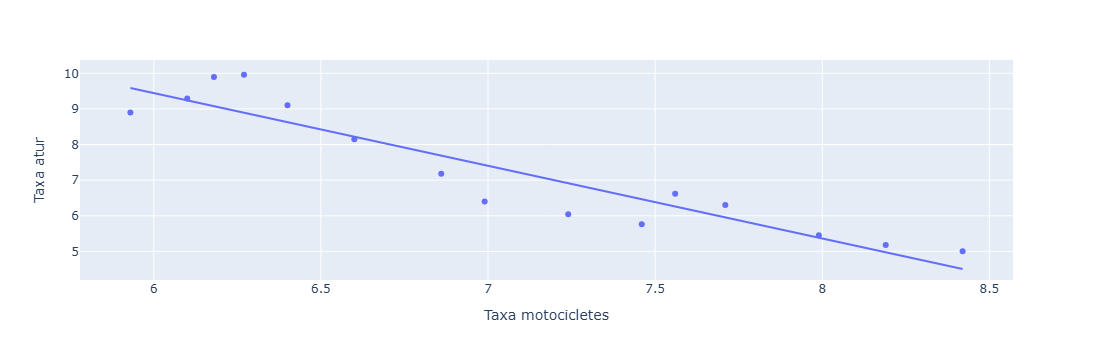

In [27]:
fig = px.scatter(df2, x='Taxa motocicletes', y='Taxa atur', trendline='ols')
fig.show()

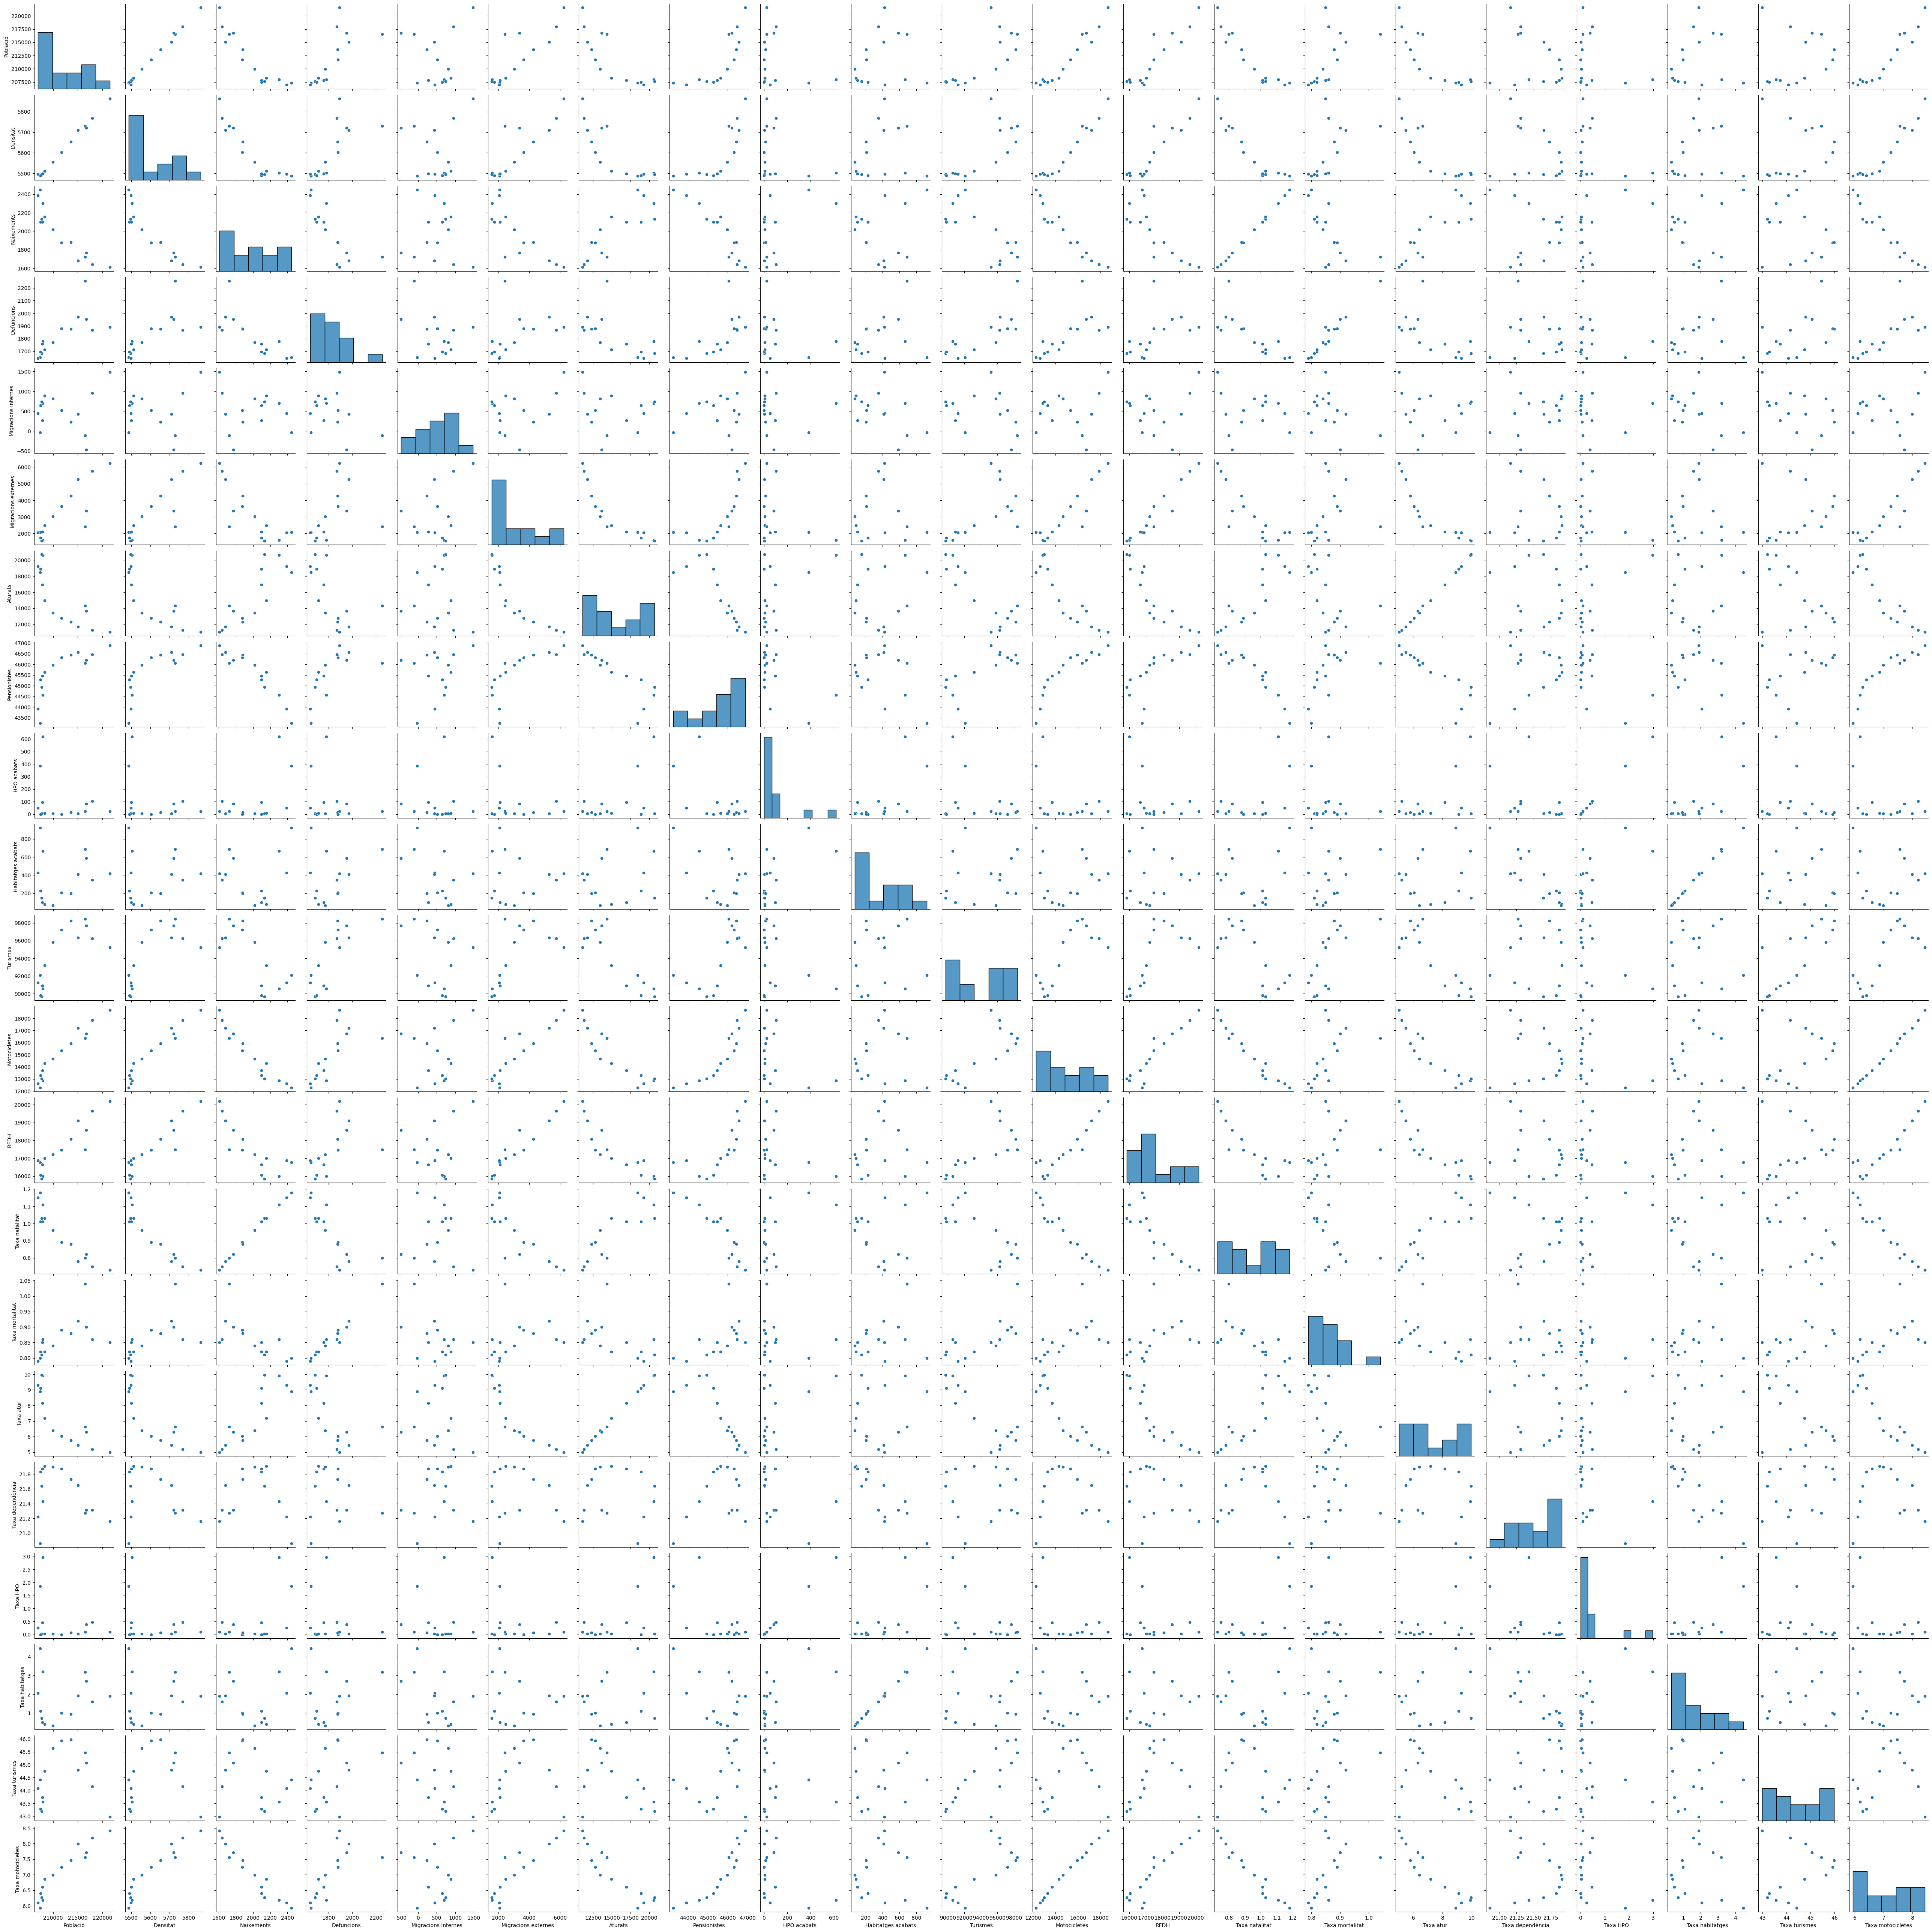

In [28]:
sns.pairplot(df2)
plt.show()

**ANÀLISI PREDICTIU**

              Variable  Coeficient
0           Naixements   -4.031836
1           Defuncions   10.193234
2  Migracions internes   -0.100560
3  Migracions externes    1.628166
[196053.55988686]
r2 = 0.907327105424261


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_6332\113110075.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



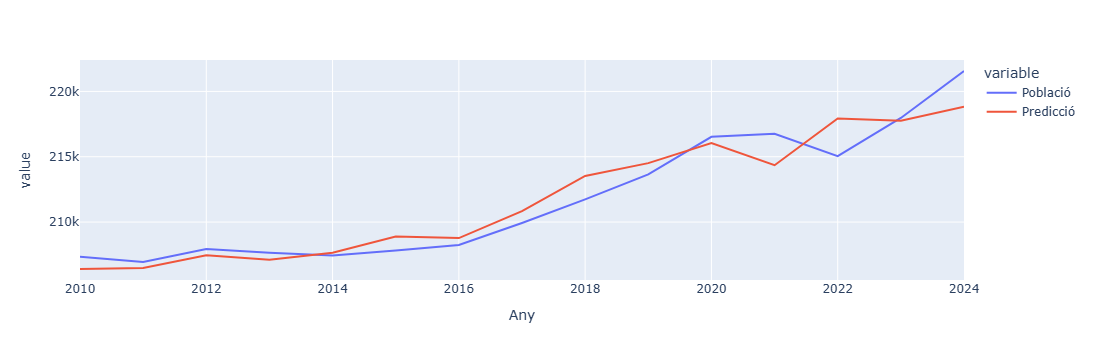

In [29]:
# Predicció de Població segons Naixements, Defuncions i Migracions

X = df2[["Naixements", "Defuncions", "Migracions internes", "Migracions externes"]]
y = df2[["Població"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Població']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()


In [30]:
# Predicció de Població segons Naixements, Defuncions i Migracions amb Random Forest

# 1. Seleccionar variables
X = df2[["Naixements", "Defuncions", "Migracions internes", "Migracions externes"]]
y = df2["Població"]

# 2. Dividir en entrenament i test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Crear i entrenar el model
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42
)

model.fit(X_train, y_train)

# 4. Avaluació
preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2:", r2)

# 5. Importància de les variables
importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))


RMSE: 1016.4840012212004
R2: 0.9327149567852112
Naixements             0.555696
Defuncions             0.253395
Migracions externes    0.142812
Migracions internes    0.048097
dtype: float64


              Variable  Coeficient
0           Naixements   -5.783301
1           Defuncions    8.408013
2              Aturats    0.329301
3         Pensionistes   -0.033374
4                 RFDH    3.496122
5  Migracions internes    0.864157
6  Migracions externes   -0.877581
[145440.33975061]
r2 = 0.966756659098953


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_6332\1570774157.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



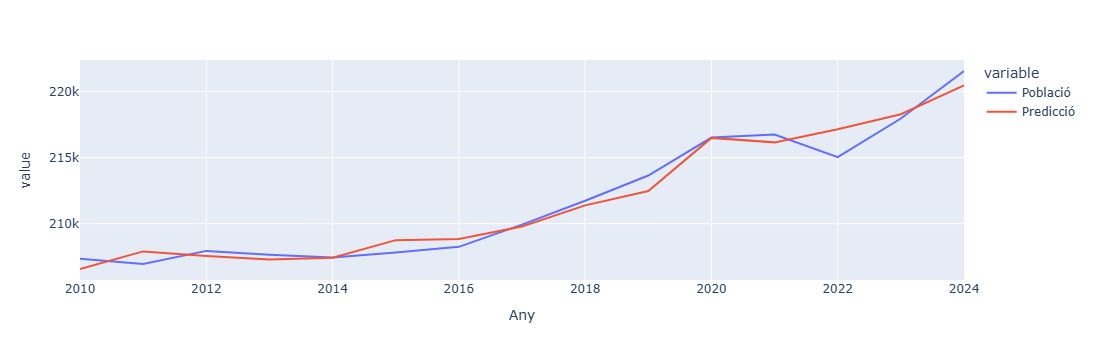

In [31]:
# Predicció de Població segons Naixements, Defuncions, Aturats, Pensionistes, RFDH i Migracions

X = df2[["Naixements", "Defuncions", "Aturats", "Pensionistes", "RFDH", "Migracions internes", "Migracions externes"]]
y = df2[["Població"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Població']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()

              Variable  Coeficient
0             Població    0.319962
1                 RFDH   -1.937596
2           Naixements   -7.821312
3           Defuncions   -6.740836
4  Migracions internes    0.853453
5  Migracions externes   -0.757493
6         Pensionistes   -2.726852
[135718.47189799]
r2 = 0.9380255560800341


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_6332\2175888387.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



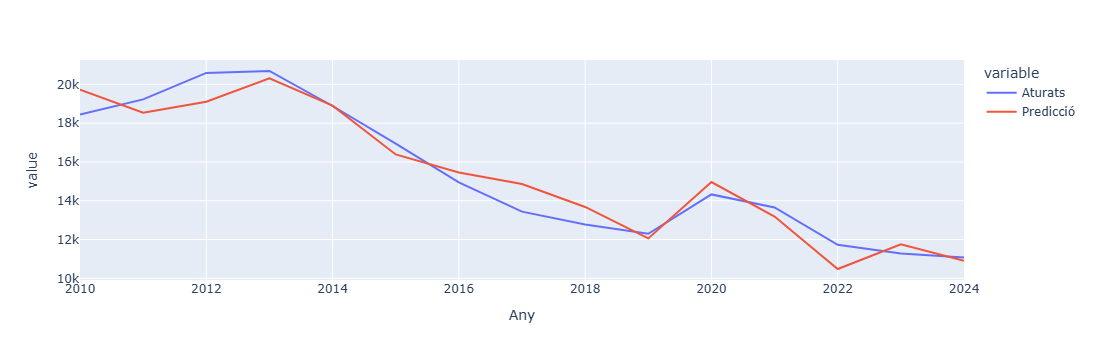

In [32]:
# Predicció del nombre d'Aturats segons Població, RFDH, Naixements, Defuncions i Migracions

X = df2[["Població", "RFDH", "Naixements", "Defuncions", "Migracions internes", "Migracions externes", "Pensionistes"]]
y = df2[["Aturats"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Aturats']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()



              Variable  Coeficient
0             Població    0.151828
1           Naixements   -0.071194
2           Defuncions   -1.290490
3  Migracions internes   -0.207546
4  Migracions externes    0.448678
5              Aturats   -0.086601
6         Pensionistes   -0.246175
[-890.68768099]
r2 = 0.9813713825088846


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_6332\791505936.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



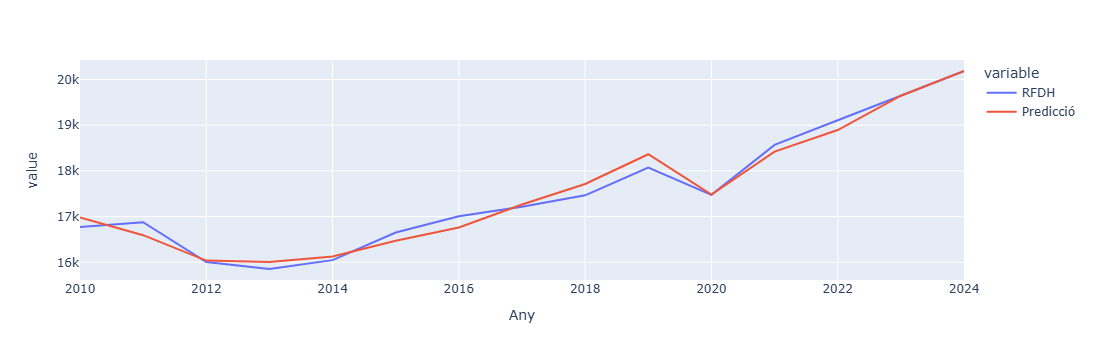

In [33]:
# Predicció del nombre de RFDH segons Població, Naixements, Defuncions, Migracions, Aturats i Pensionistes

X = df2[["Població", "Naixements", "Defuncions", "Migracions internes", "Migracions externes", "Aturats", "Pensionistes"]]
y = df2[["RFDH"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['RFDH']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()

                               SARIMAX Results                                
Dep. Variable:               Població   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -124.663
Date:                Thu, 05 Feb 2026   AIC                            255.326
Time:                        10:27:43   BIC                            257.243
Sample:                    01-01-2010   HQIC                           255.148
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5791      5.040     -0.115      0.909     -10.457       9.298
ma.L1          0.5756      5.073      0.113      0.910      -9.368      10.519
sigma2      2.583e+06    1.2e-05   2.15e+11      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



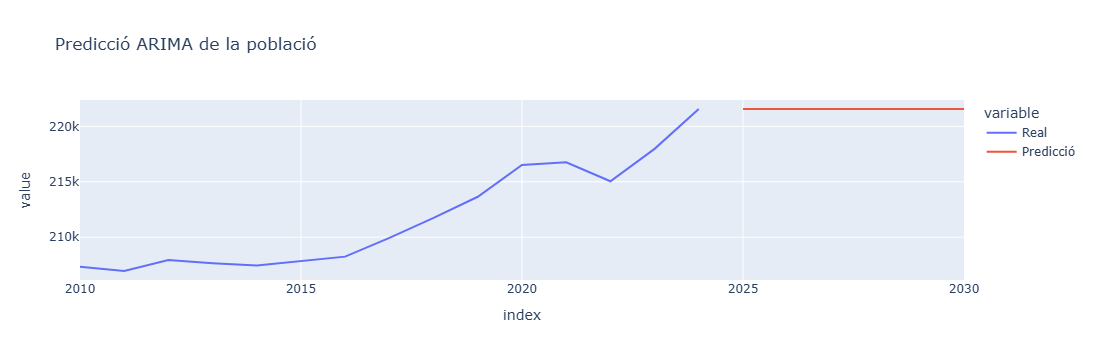

In [34]:
# Prediccions de Població al futur amb ARIMA

s = df2["Població"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de la població")
fig.show()



                               SARIMAX Results                                
Dep. Variable:                   RFDH   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -106.970
Date:                Thu, 05 Feb 2026   AIC                            219.940
Time:                        10:27:44   BIC                            221.857
Sample:                    01-01-2010   HQIC                           219.762
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.025     39.828      0.000       0.951       1.049
ma.L1         -0.9964      0.439     -2.269      0.023      -1.857      -0.136
sigma2      2.495e+05   1.74e-06   1.44e+11      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



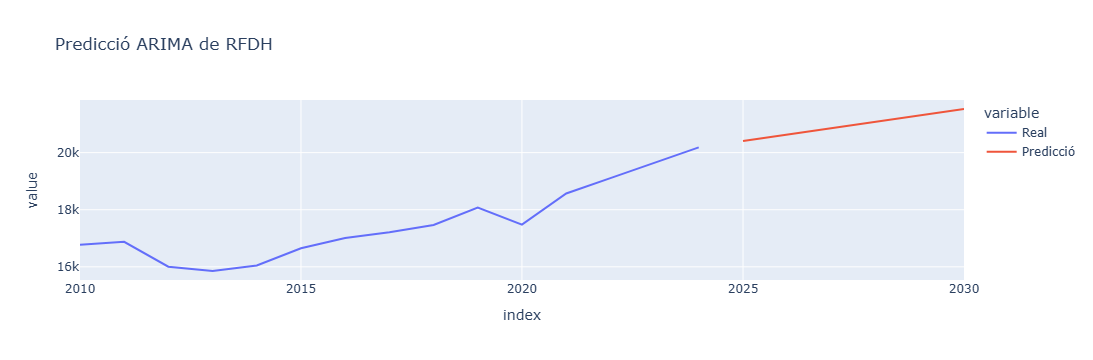

In [35]:
# Prediccions de RFDH al futur amb ARIMA

s = df2["RFDH"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de RFDH")
fig.show()

                               SARIMAX Results                                
Dep. Variable:                Aturats   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -119.578
Date:                Thu, 05 Feb 2026   AIC                            245.155
Time:                        10:27:45   BIC                            247.073
Sample:                    01-01-2010   HQIC                           244.978
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3726      0.817      0.456      0.648      -1.229       1.974
ma.L1         -0.2271      0.897     -0.253      0.800      -1.985       1.531
sigma2      1.328e+06    7.6e+05      1.747      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



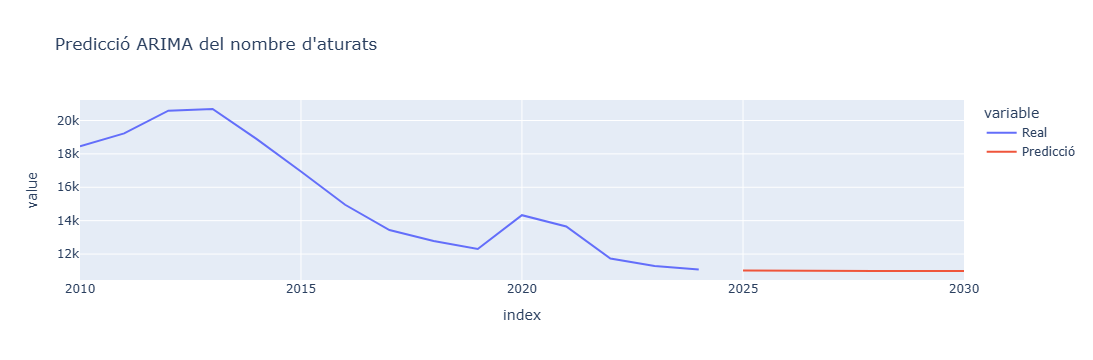

In [36]:
# Prediccions de Aturats al futur amb ARIMA

s = df2["Aturats"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA del nombre d'aturats")
fig.show()

                               SARIMAX Results                                
Dep. Variable:     Habitatges acabats   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -95.132
Date:                Thu, 05 Feb 2026   AIC                            196.264
Time:                        10:27:45   BIC                            198.181
Sample:                    01-01-2010   HQIC                           196.087
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9374      0.151     -6.189      0.000      -1.234      -0.641
ma.L1          0.6551      0.441      1.484      0.138      -0.210       1.520
sigma2      4.552e+04   2.45e+04      1.857      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



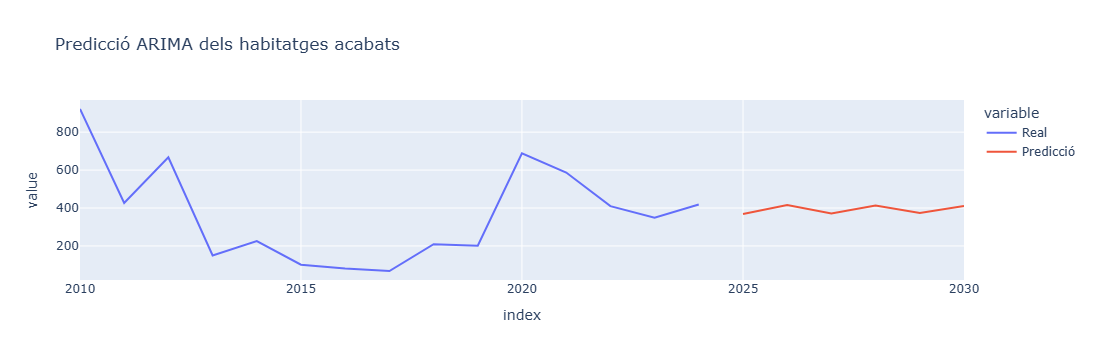

In [37]:
# Prediccions de Habitatges acabats al futur amb ARIMA

s = df2["Habitatges acabats"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA dels habitatges acabats")
fig.show()

                               SARIMAX Results                                
Dep. Variable:             Naixements   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -81.352
Date:                Thu, 05 Feb 2026   AIC                            168.704
Time:                        10:27:53   BIC                            170.621
Sample:                    01-01-2010   HQIC                           168.526
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.004    247.494      0.000       0.992       1.008
ma.L1         -0.9971      0.764     -1.306      0.192      -2.494       0.499
sigma2      5494.5577      0.000    3.9e+07      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



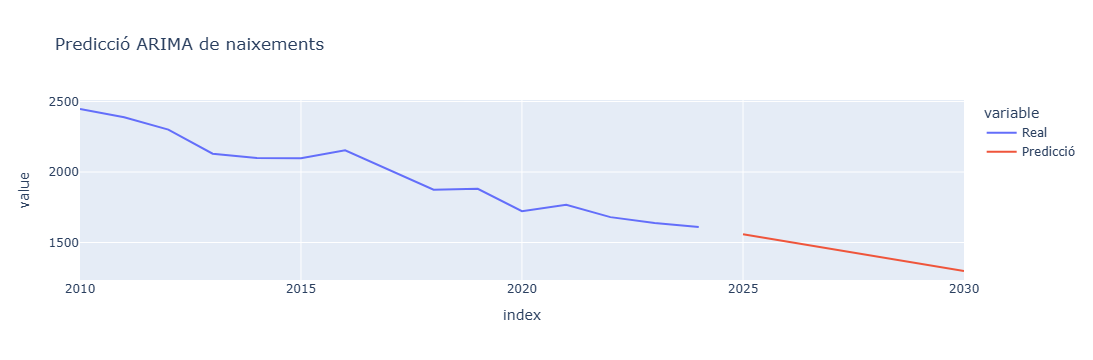

In [38]:
# Prediccions de Naixements acabats al futur amb ARIMA

s = df2["Naixements"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de naixements")
fig.show()

                               SARIMAX Results                                
Dep. Variable:             Defuncions   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -87.849
Date:                Thu, 05 Feb 2026   AIC                            181.697
Time:                        10:27:55   BIC                            183.614
Sample:                    01-01-2010   HQIC                           181.520
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5360      0.667     -0.804      0.422      -1.843       0.771
ma.L1          0.1176      0.795      0.148      0.882      -1.441       1.676
sigma2      1.627e+04   4729.881      3.441      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



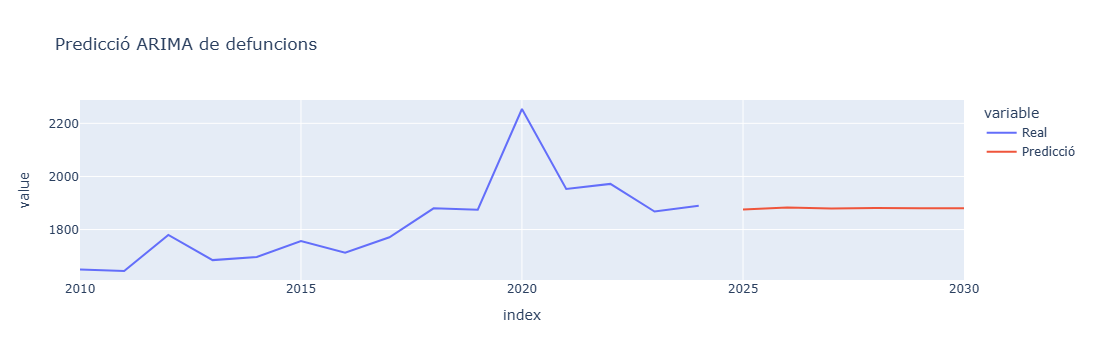

In [39]:
# Prediccions de Defuncions al futur amb ARIMA

s = df2["Defuncions"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de defuncions")
fig.show()